In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Test/VietTri.csv')

In [37]:
def train_test_split_and_predict(df, train_ratio=0.7, tol=1e-6, max_iter=100, predict_days=[30, 60, 90]):
    # Convert the 'date' column to datetime format
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
    df = df[df['date'] < '2024-06-01']

    # Calculate train and test sizes
    train_size = int(train_ratio * len(df))
    test_size = len(df) - train_size

    # Split the data
    train_data = df[:train_size]
    test_data = df[train_size:]

    # Separate features and target variable
    X_train = train_data['Index']
    X_test = test_data['Index']
    y_train = train_data['AQI']
    y_test = test_data['AQI']

    # Define the model function
    def f(x, c0, c1, c2, c3, c4):
        return c0 * x**3 + c1 * x**2 + c2 * x + c3 + c4 * np.sin(x)

    # Define the Jacobian matrix
    def jacobian(x, c0, c1, c2, c3, c4):
        J = np.empty((x.size, 5))
        J[:, 0] = x**3
        J[:, 1] = x**2
        J[:, 2] = x
        J[:, 3] = 1
        J[:, 4] = np.sin(x)
        return J

    # Gauss-Newton optimization
    def Gauss_Newton(f, jacobian, X, y, initial_params, tol, max_iter):
        params = np.array(initial_params)
        for i in range(max_iter):
            residuals = y - f(X, *params)
            J = jacobian(X, *params)
            delta = np.linalg.lstsq(J, residuals, rcond=None)[0]
            params += delta
            if np.linalg.norm(delta) < tol:
                break
        return params

    # Initial guess for the parameters
    initial_params = [1.0, 1.0, 1.0, 1.0, 1.0]

    # Perform the Gauss-Newton optimization
    estimated_parameters = Gauss_Newton(f, jacobian, X_train, y_train, initial_params, tol, max_iter)

    # Calculate y_pred using the estimated parameters
    y_pred = f(X_test, *estimated_parameters)

    # Calculate MAE, RMSE, and MAPE for test predictions
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')

    # Predict future values
    last_value = X_test.iloc[-1]
    start_index_day = last_value + 1

    # Generate predictions for specified days
    for days in predict_days:
        X_predict = pd.Series(range(start_index_day, start_index_day + days))
        y_predict = f(X_predict, *estimated_parameters)

        plt.figure(figsize=(10, 5))
        plt.plot(X_train, y_train, 'bo', label='Training data')
        plt.plot(X_test, y_test, 'ro', label='Test data')
        plt.plot(X_test, y_pred, 'g-', label='Predicted data')
        plt.plot(X_predict, y_predict, 'b-', label=f'Predicted data {days} days')
        plt.title(f'{days} Days Prediction')
        plt.xlabel('Date Number')
        plt.ylabel('AQI')
        plt.legend()
        plt.show()

MAE: 49.958839395151735
RMSE: 56.591099874277546
MAPE: 1.439959197148476


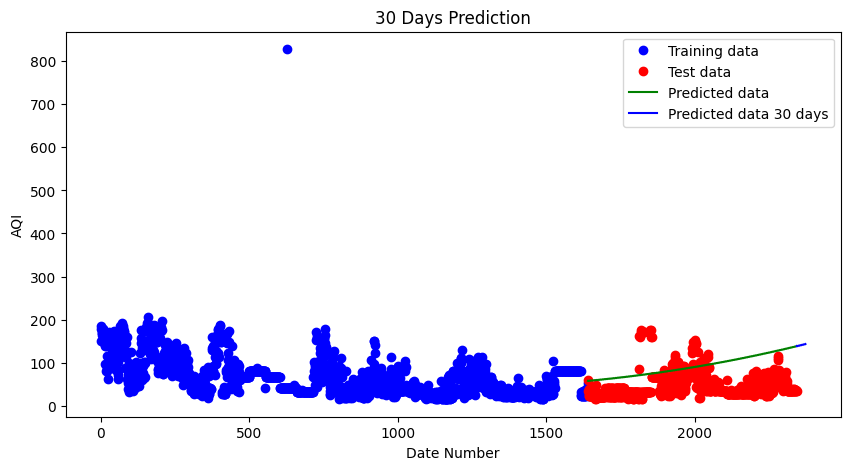

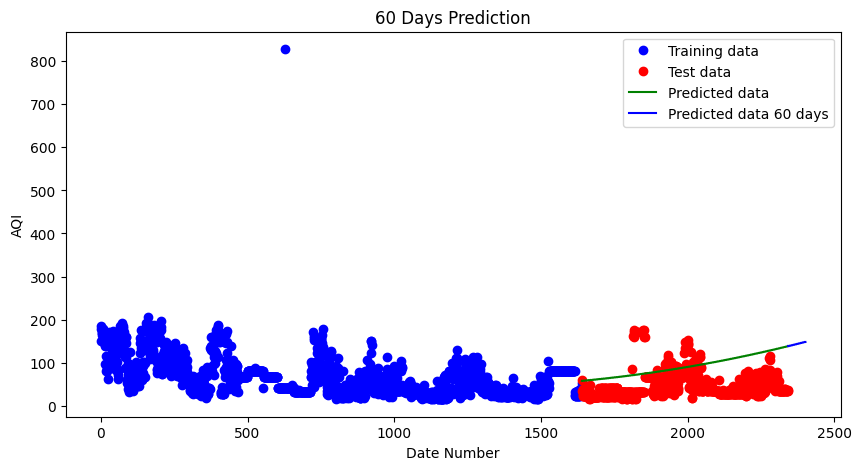

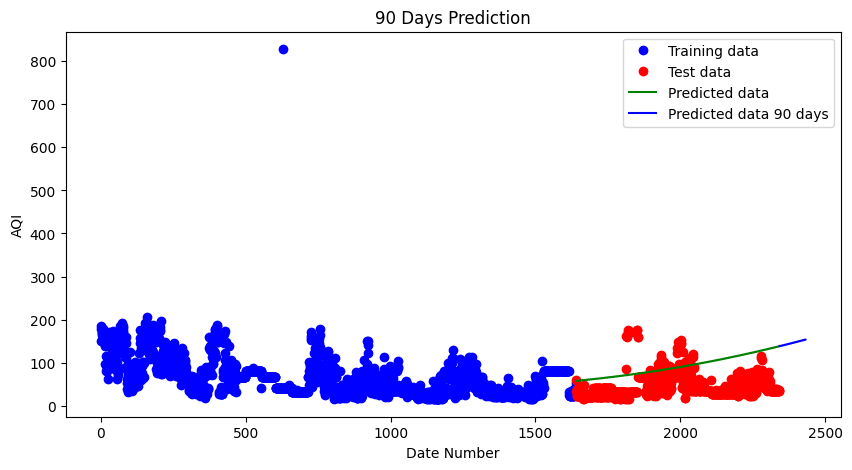

MAE: 19.29482153825965
RMSE: 25.190283778661147
MAPE: 0.3911070410706915


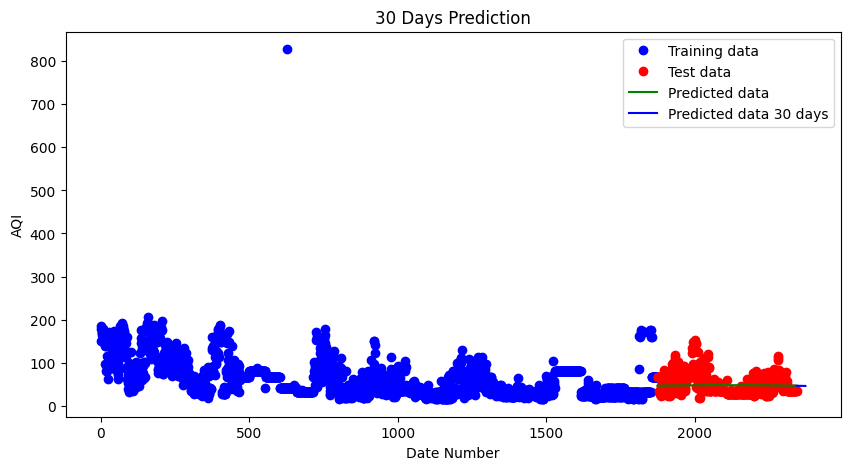

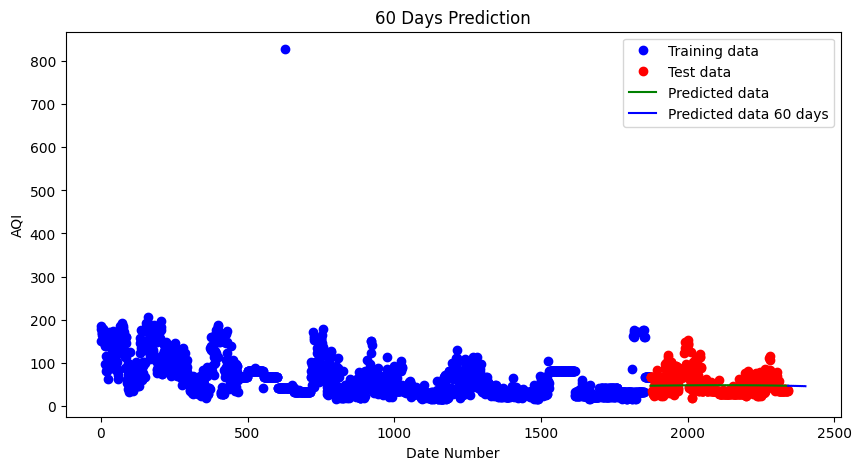

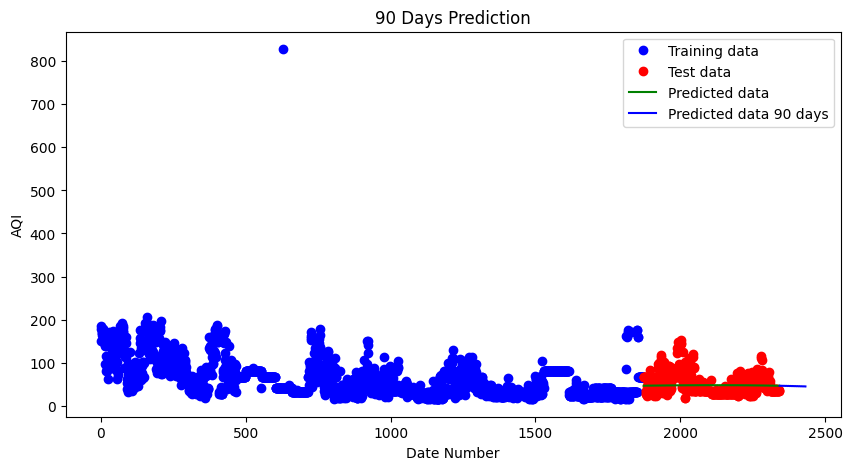

MAE: 25.230569379167022
RMSE: 28.01701531598735
MAPE: 0.7627394488212952


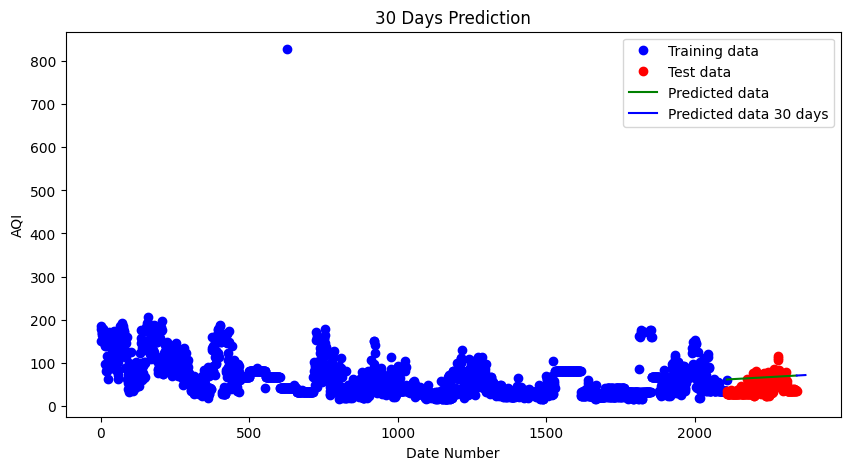

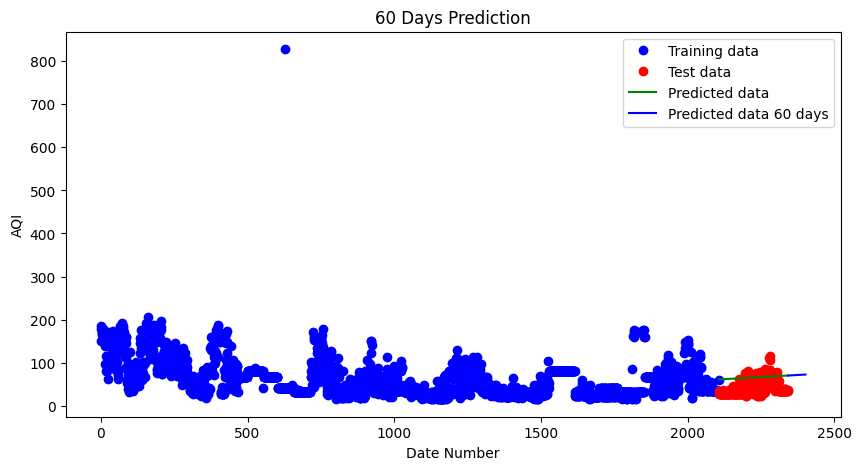

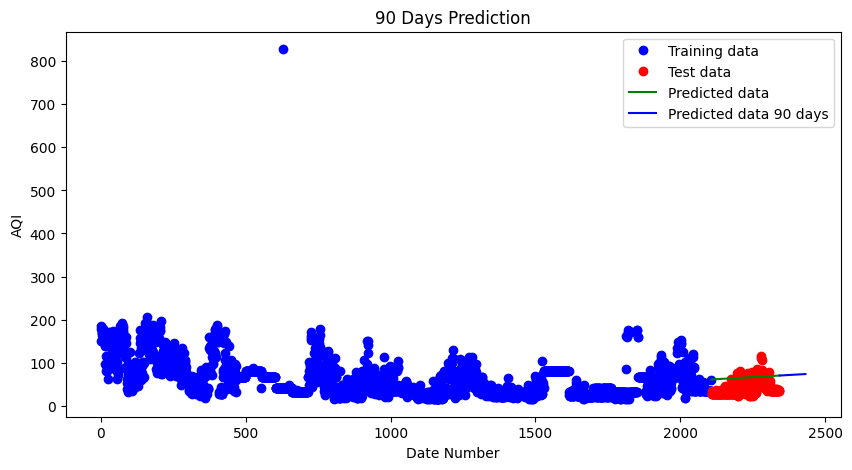

In [44]:
train_test_split_and_predict(df, train_ratio=0.7, predict_days=[30, 60, 90])
train_test_split_and_predict(df, train_ratio=0.8, predict_days=[30, 60, 90])
train_test_split_and_predict(df, train_ratio=0.9, predict_days=[30, 60, 90])